Discrete Laplacian

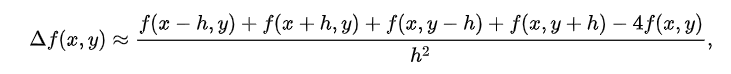

In [1]:
import numpy as np
from numba import njit, prange
from tqdm import tqdm


def get_laplacian(dx):
    @njit(parallel=True)
    def laplacian(board):
        # return np.roll(f,1,0)+np.roll(f,-1,0)+np.roll(f,1,1)+np.roll(f,-1,1)-4*f
        lap = np.zeros_like(board)
        n_rows = board.shape[0]
        n_cols = board.shape[1]

        for i in prange(n_rows):
            u = i+1 == n_rows
            d = i-1 == -1
            for j in range(n_cols):
                l = j-1 == -1
                r = j+1 == n_cols
                p1 = 0 if u else board[i+1, j]
                p2 = 0 if d else board[i-1 ,j]
                p4 = 0 if l else board[i, j-1]
                p3 = 0 if r else board[i, j+1]

                lap[i,j] = p1 + p2 + p3 + p4 - (4 - (u + d + l + r))*board[i,j]
    
        lap /= dx*dx

        return lap
    return laplacian

# @njit
def get_equations(dx, D_p, D_q, C, K):
    laplacian = get_laplacian(dx)
    @njit
    def dp_dt(p_q):
        p = p_q[:,:,0]
        q = p_q[:,:,1]
        return D_p*laplacian(p) + p*p*q + C - (K+1)*p
    
    @njit
    def dq_dt(p_q):
        p = p_q[:,:,0]
        q = p_q[:,:,1]
        return D_q*laplacian(q) - p*p*q + K*p
    
    return dp_dt, dq_dt

# @njit
def get_step(dt, dp_dt, dq_dt):
    @njit
    def step(p_q):
        p = p_q[:,:,0]
        q = p_q[:,:,1]
        p += dp_dt(p_q)*dt
        q += dq_dt(p_q)*dt
        return p_q
    return step

@njit
def the_loop(p_q, n_steps : int, step):
    for i in (prange(n_steps)):
        p_q = step(p_q)

        if np.isnan(p_q).all():
            print("nan",i)
            break
    return p_q

# @njit
def simulate(dt, dx, T, D_p, D_q, C, K):
    n_steps = int(T/dt)

    N = int(40/dx)
    inner = int(10/dx)
    outer = int(30/dx)

    p_q = np.zeros((N, N, 2), dtype=np.float64)

    # p_q_hist = np.zeros((n_steps, N, N, 2), dtype=np.float64)
    # p_q_hist[0] = p_q

    p_q[inner:outer,inner:outer,0] = C + 0.1
    p_q[inner:outer,inner:outer,1] = K/C + 0.2

    dp_dt, dq_dt = get_equations(dx, D_p, D_q, C, K)

    step = get_step(dt, dp_dt, dq_dt)


    p_q = the_loop(p_q, n_steps, step)


        # p_q_hist[i] = p_q
    
    # return p_q_hist
    return p_q


# pq = simulate(dt = 0.001, dx = 0.5, T = 2000, D_p = 1, D_q = 8, C = 4.5, K = 9)


In [9]:
# sims = []
for K in tqdm([7,8,9,10,11,12]):
    pq = simulate(dt = 0.001, dx = 0.5, T = 2000, D_p = 1, D_q = 8, C = 4.5, K = K)
    sims.append(pq)

    # plt.imshow(pq_hist[:,:,1])

 83%|████████▎ | 5/6 [41:44<08:08, 488.49s/it]

In [ ]:
import matplotlib.pyplot as plt

for s in sims:
    plt.imshow(s[:, :, 0])
    plt.colorbar()
    plt.show()



IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [ ]:
for s in sims:
    # draw countours
    plt.contour(s[:, :, 0], levels=[4.5], colors='red')
    plt.contour(s[:, :, 1], levels=[9], colors='blue')
    plt.show()
    